In [ ]:
from audiolazy import lpc
import parselmouth
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal, integrate
import sounddevice as sd

In [ ]:
inpFolder = './emoDB/wav/'
file1 = inpFolder+'08a01Fd.wav'
file2 = inpFolder+'08a01Na.wav'

In [ ]:
def plot_pitch(pitch):
    pitch_values = pitch.selected_array['frequency']
    
    # replace unvoiced samples by NaN to not plot
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values,'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values,'o', markersize=4)
    
    plt.grid(True)
    plt.ylim(0, pitch.ceiling/2)
    plt.ylabel("Pitch(Hz)")
    plt.xlabel("Time(sec)")
    plt.title('Pitch Contour')

In [ ]:
#Zero frequency filtering
def zff(sigslice,pitchdur,fs):    
    x_n = (sigslice - np.roll(sigslice,1))[1:] #pre-emphasis
    y1_n = signal.filtfilt(1,[-2,1],x_n)  #1st zff
    y2_n = signal.filtfilt(1,[-2,1],y1_n) #2nd zff
    y_n = y2_n
    n = len(y_n)

    meanlen = int(pitchdur*fs/1000)
    ml = int(meanlen/2)

    for i in range(n):
        y_n[i] -= np.mean(y2_n[max(0,i-ml):min(n,i+ml)])
    return y_n

In [ ]:
#Finding glottal closure instant(gci) locations using zero crossings
def zerocrossing(zffOut):
    n = len(zffOut)
    
    locs = [i for i in range(1,n-1) if ((zffOut[i]==0 and zffOut[i+1]>0 and zffOut[i-1]<0) or (zffOut[i]<0 and zffOut[i+1]>0))]
    #Base case
    if len(locs)==0 or len(locs)==1:
        return locs
    moving_time_diff = [j-i for i, j in zip(locs[:-1], locs[1:])]
    mean_diff = np.mean(moving_time_diff)/2
    
    #remove the zero crossings that are too close to each other
    gci = [locs[i] for i in range(len(locs)-1) if locs[i+1]-locs[i]>mean_diff]
    
    if [locs[-1] - locs[-2]] > mean_diff:
        gci.append(locs[-1])
    return gci

In [ ]:
def lpresidual(window, gci, slice_1ms):
    filt = lpc.kautocor(window, 10)
    a = filt.numerator
    padlen = min(len(3*a[1:]),len(window)-1) #Adjusting padlength to avoid error of windowlength < padlength. Default padlen = 3 * a[1:]]
    ex = signal.filtfilt(a[1:],1,window,padlen = padlen)
    hilbert = signal.hilbert(ex) 
    env = np.abs(hilbert)
    eoe = []
    
    for gciInd in gci: 
        segment = env[max(0, gciInd - slice_1ms):min(len(env), gciInd + slice_1ms)]
        eoe.append(np.sum(segment**2))
    
    return eoe[1:]

In [ ]:
def feature_extract(filename):
    fs, data = wavfile.read(filename)
    #data = data/np.max(data)
    data = np.array(data,dtype = np.float64)
#     plt.figure()
#     plt.plot(data)
#     plt.figure()
    
    snd = parselmouth.Sound(filename)
    pitch = snd.to_pitch()
#     plot_pitch(pitch)
    
    #Calculating the avg. pitch freq and period
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    meanpitch = np.nanmean(pitch_values)
    pitchdur = 1/meanpitch * 1000
    #print("Avg pitch = {a} Hz and avg pitch duration = {b} ms".format(a = meanpitch, b = pitchdur))

    #removing the unvoiced regions using energy thresholding
    energy = data**2
    maxenergy = np.max(data**2)
    threshold = maxenergy/20
#     plt.figure()
#     plt.plot(energy)
#     plt.title('Energy')
    
    voiced = np.array([ele for ele in data if ele**2 >= threshold ])
#     plt.figure()
#     plt.plot(voiced)
#     plt.title('Voiced Speech')
    
    #extracting the features frame by frame
    frame = int(16 * fs/1000)
    slice_1ms = frame // 20

    n = len(voiced)
    instant_freq = []
    soe_feature = []
    eoe_feature = []
    zff_plot = []
    gci_plot = []
    for index in range(0,n,frame):
        eoe = []
        sigslice = voiced[index:min(n,index+frame)]
        if len(sigslice)<30:
            continue
        
        zffOut = zff(sigslice, pitchdur, fs)
        
        gci = zerocrossing(zffOut)
        gci_plot.extend([x+len(zff_plot) for x in gci])

        zff_plot.extend(zffOut)

        #instanteneous frequency
        freq_sample = [fs/(gci[i+1] - gci[i]) for i in range(len(gci)-1)]
        instant_freq.extend(freq_sample)

        #strength of excitation
        soe = [(zffOut[gciInd+1]-zffOut[gciInd-1])/2 for gciInd in gci]
        soe_feature.extend(soe[1:])

        #energy of excitation
        eoe_feature.extend(lpresidual(sigslice, gci, slice_1ms))

    instant_freq = np.array(instant_freq)
    soe_feature = np.array(soe_feature)
    eoe_feature = np.array(eoe_feature)
    
#     plt.figure(figsize=(15,15))
#     plt.plot(zff_plot)
#     plt.scatter(gci_plot,[zff_plot[x] for x in gci_plot], color='orange')
#     print(len(zff_plot), len(gci_plot))
    
    #instant_freq, soe_feature, eoe_feature = normalisefeature(instant_freq,soe_feature,eoe_feature)
    return instant_freq, soe_feature, eoe_feature

In [ ]:
def normalisefeature(f0,soe_feature,eoe_feature,mi,ms,me,si,ss,se): 
    f0 = (f0 - mi)/si
    soe_feature = (soe_feature - ms)/ss
    eoe_feature = (eoe_feature - me)/se
    return f0,soe_feature,eoe_feature

In [ ]:
i1, s1, e1 = feature_extract(file2)
mi , ms, me = np.mean(i1),np.mean(s1),np.mean(e1)
si,ss,se = np.std(i1),np.mean(s1),np.mean(e1)

#i1, s1, e1 = normalisefeature(i1,s1,e1,mi,ms,me,si,ss,se)
i2, s2, e2 = feature_extract(file1)
#i2, s2, e2 = normalisefeature(i2,s2,e2,mi,ms,me,si,ss,se)

print(i1.shape, s1.shape, e1.shape)
print(i2.shape, s2.shape, e2.shape)

(98,) (98,) (98,)
(320,) (320,) (320,)


In [ ]:
# plt.scatter(s1,i1,marker='.',label='Neutral')
# plt.scatter(s2,i2,marker='x',label='Happy')
# plt.xlabel('SoE')
# plt.ylabel('F0')
# plt.legend()

In [ ]:
# plt.scatter(e1,i1,marker='.',label='Neutral')
# plt.scatter(e2,i2,marker='x',label='Happy')
# plt.xlabel('EoE')
# plt.ylabel('F0')
# plt.legend()

In [ ]:
# plt.scatter(s1,e1,marker='.',label='Neutral')
# plt.scatter(s2,e2,marker='x',label='Happy')
# plt.xlabel('SoE')
# plt.ylabel('EoE')
# plt.legend()

In [ ]:
def extract_2D_features(filename):
    i, soe, eoe = feature_extract(filename)
    return i,soe,eoe

In [ ]:
def neutral_features(inpFolder): 
    i = 0
    #Speaker list
    speakers = ['03','08','09','10','11','12','13','14','15','16']
    #Initialising
    import os
    neutral = np.empty((0,3),float)
    neutral_temp = np.empty((0,3),float)
    mean_speakers = np.empty((0,3),float) 
    std_speakers = np.empty((0,3),float)
    with os.scandir(inpFolder) as entries:
            for entry in entries:
                if entry.name[:2] == speakers[i]:
                    #Storing all neutral features of one speaker in an N dim array
                    if entry.name[5]=='N': 
                        f0,soe,eoe = extract_2D_features(inpFolder+entry.name)
                        features = np.column_stack((f0,soe,eoe))
                        neutral_temp = np.row_stack((neutral_temp,features))

                else:
                    i+=1
                    #Storing the mean value of one speaker for neutral emotion
                    mean_speakers = np.row_stack((mean_speakers,np.mean(neutral_temp,axis = 0)))
                    #Storing the std value of one speaker for neutral emotion
                    std_speakers = np.row_stack((std_speakers,np.std(neutral_temp,axis = 0)))
                    neutral_temp = (neutral_temp - np.mean(neutral_temp,axis = 0))/np.std(neutral_temp,axis = 0) # Normalising the neutral feature
                    neutral = np.row_stack((neutral,neutral_temp))
                    neutral_temp = np.empty((0,3),float)
    #Storing for the last speaker, because its missed in the loop
    mean_speakers = np.row_stack((mean_speakers,np.mean(neutral_temp,axis = 0))) 
    std_speakers = np.row_stack((std_speakers,np.std(neutral_temp,axis = 0)))
    neutral_temp = (neutral_temp - np.mean(neutral_temp,axis = 0))/np.std(neutral_temp,axis = 0)
    neutral = np.row_stack((neutral,neutral_temp))
    return neutral,speakers,mean_speakers,std_speakers
    

In [ ]:
def create_Data_matrix(neutral,speakers,mean_speakers,std_speakers,inpFolder = './emoDB/wav/',):
    
    f0_train = np.empty((0),float)
    soe_train = np.empty((0),float)
    eoe_train = np.empty((0),float)
    #Fetching neutral features, speakerwise mean, speakerwise standard deviation
    
    i = 0
    import os
    with os.scandir(inpFolder) as entries:
        for entry in entries:
            if entry.name[:2]==speakers[i]:
                if entry.name[5] == 'W' or entry.name[5] == 'F' or entry.name[5] == 'T' or entry.name[5] == 'N' :
                    f0, soe, eoe  = extract_2D_features(inpFolder+entry.name)
                    f0 = (f0 - mean_speakers[i,0])/std_speakers[i,0]
                    soe = (soe - mean_speakers[i,1])/std_speakers[i,1]
                    eoe = (eoe - mean_speakers[i,2])/std_speakers[i,2]#Normalising speakerwise
                    
                    
                    pad = max(f0_train.T.shape[0],f0.shape[0])
                    if f0_train.T.shape[0] == 0:
                        pad = pad -1
                   

                    if f0_train.T.shape[0] < f0.shape[0]:
                        f0_train = np.column_stack((f0_train,np.zeros((f0_train.shape[0],pad-f0_train.T.shape[0]))))
                        soe_train = np.column_stack((soe_train,np.zeros((soe_train.shape[0],pad-soe_train.T.shape[0]))))
                        eoe_train = np.column_stack((eoe_train,np.zeros((eoe_train.shape[0],pad-eoe_train.T.shape[0]))))
                    if f0_train.T.shape[0] > f0.shape[0]:
                        f0 = np.append(f0,np.zeros(pad-f0.shape[0]))
                        soe = np.append(soe,np.zeros(pad-soe.shape[0]))
                        eoe = np.append(eoe,np.zeros(pad-eoe.shape[0]))
                    f0_train = np.row_stack((f0_train,f0.T))
                    soe_train = np.row_stack((soe_train,soe.T))
                    eoe_train = np.row_stack((eoe_train,eoe.T))     
                    
            else:
                i+=1 #We go to the next speaker
                if entry.name[5] == 'W' or entry.name[5] == 'F' or entry.name[5] == 'T' or entry.name[5] == 'N': 
                    f0, soe, eoe  = extract_2D_features(inpFolder+entry.name)
                    f0 = (f0 - mean_speakers[i,0])/std_speakers[i,0]
                    soe = (soe - mean_speakers[i,1])/std_speakers[i,1]
                    eoe = (eoe - mean_speakers[i,2])/std_speakers[i,2]#Normalising speakerwise
                    
                    pad = max(f0_train.T.shape[0],f0.shape[0])

                    if f0_train.T.shape[0] < f0.shape[0]:
                        f0_train = np.column_stack((f0_train,np.zeros((f0_train.shape[0],pad-f0_train.T.shape[0]))))
                        soe_train = np.column_stack((soe_train,np.zeros((soe_train.shape[0],pad-soe_train.T.shape[0]))))
                        eoe_train = np.column_stack((eoe_train,np.zeros((eoe_train.shape[0],pad-eoe_train.T.shape[0]))))
                    if f0_train.T.shape[0] > f0.shape[0]:
                        f0 = np.append(f0,np.zeros(pad-f0.shape[0]))
                        soe = np.append(soe,np.zeros(pad-soe.shape[0]))
                        eoe = np.append(eoe,np.zeros(pad-eoe.shape[0]))
                    f0_train = np.row_stack((f0_train,f0.T))
                    soe_train = np.row_stack((soe_train,soe.T))
                    eoe_train = np.row_stack((eoe_train,eoe.T))
    return f0_train,soe_train,eoe_train

In [ ]:
def create_labels(f0_train,soe_train,eoe_train):
    import os
    y_label = np.asarray([])
    with os.scandir(inpFolder) as entries:
        for entry in entries:

                if entry.name[5] == 'W' or entry.name[5] == 'F' or entry.name[5] == 'T' or entry.name[5] == 'N' :
                        if entry.name[5] == 'W':
                            y = 0
                        if entry.name[5] == 'F':
                            y = 1
                        if entry.name[5] == 'T':
                            y = 2
                        if entry.name[5] == 'N':
                            y = 3
                        y_label = np.append(y_label,y)
    f0_train,soe_train,eoe_train = np.column_stack((f0_train,y_label)),np.column_stack((soe_train,y_label)),np.column_stack((eoe_train,y_label))
    return f0_train,soe_train,eoe_train

In [ ]:
neutral,speakers,mean_speakers,std_speakers = neutral_features(inpFolder) 

<ipython-input-40-df0dde4c8ec5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)


In [ ]:
f0_train,soe_train,eoe_train = create_Data_matrix(neutral,speakers,mean_speakers,std_speakers,inpFolder = './emoDB/wav/')

<ipython-input-40-df0dde4c8ec5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)


In [ ]:
#Creating labels
f0_train,soe_train,eoe_train = create_labels(f0_train,soe_train,eoe_train)

In [ ]:
F0_train_initial,F0_test_initial = f0_train[:259,:],f0_train[259:,:]
Soe_train_initial,Soe_test_initial = soe_train[:259,:],soe_train[259:,:]
Eoe_train_initial,Eoe_test_initial = eoe_train[:259,:],eoe_train[259:,:]
n = num_samples_in_each_class_for_training = 45
d = F0_train_initial.shape[1]-1 #Dimension
F0_train,Soe_train,Eoe_train = np.empty((0,F0_train_initial.shape[1]),float),np.empty((0,F0_train_initial.shape[1]),float),np.empty((0,F0_train_initial.shape[1]),float)
F0_test,Soe_test,Eoe_test = np.empty((0,F0_train_initial.shape[1]),float),np.empty((0,F0_train_initial.shape[1]),float),np.empty((0,F0_train_initial.shape[1]),float)
for i in range(4):
    F0,Soe,Eoe = F0_train_initial[np.where(F0_train_initial[:,d]==i)][:n,:],Soe_train_initial[np.where(Soe_train_initial[:,d]==i)][:n,:],Eoe_train_initial[np.where(Eoe_train_initial[:,d]==i)][:n,:]
    F0_train,Soe_train,Eoe_train = np.row_stack((F0_train,F0)),np.row_stack((Soe_train,Soe)),np.row_stack((Eoe_train,Eoe))

n = num_samples_in_each_class_for_training = 15    
for i in range(4):
    F0,Soe,Eoe = F0_test_initial[np.where(F0_test_initial[:,d]==i)][:n,:],Soe_test_initial[np.where(Soe_test_initial[:,d]==i)][:n,:],Eoe_test_initial[np.where(Eoe_test_initial[:,d]==i)][:n,:]
    F0_test,Soe_test,Eoe_test = np.row_stack((F0_test,F0)),np.row_stack((Soe_test,Soe)),np.row_stack((Eoe_test,Eoe))
print(F0_train.shape,F0_test.shape)

(180, 451) (60, 451)


In [ ]:
from scipy.spatial import distance
test_arr_sum = np.empty((0,2),float)
y_predict = np.asarray([])
#Taking the first test sample
for n in range(F0_test.shape[0]):
    test_f0,test_soe,test_eoe = F0_test[n,:],Soe_test[n,:],Eoe_test[n,:]
    test_arr_sum = np.empty((0,2),float)
    #dropping  the last element which is class label
    test_f0,test_soe,test_eoe = np.delete(test_f0,d,0),np.delete(test_soe,d,0),np.delete(test_soe,d,0)
    np.where(F0_test[:,d]==3)
    for i in range(F0_train.shape[0]):
        d1 = distance.euclidean(F0_train[i,:d],test_f0)
        d2 = distance.euclidean(Soe_train[i,:d],test_soe)
        d3 = distance.euclidean(Eoe_train[i,:d],test_eoe)
        sum_dist = np.sqrt(d1*d1 + d2*d2 + d3*d3)
        test_arr_sum = np.row_stack((test_arr_sum,np.asarray([sum_dist,int(F0_train[i,d])])))
    K = 8
    test_label = test_arr_sum[np.argsort(test_arr_sum[:,0])][:K,1] #Taking K = 8
    test_label = test_label.astype(int)
    y_pred = np.bincount(test_label).argmax() #Predicted y
    y_predict = np.append(y_predict,y_pred)   

In [ ]:
accuracy = np.sum(F0_test[:,d]==y_predict)/(F0_test.shape[0])*100
print("Accuracy = ",accuracy)

Accuracy =  78.33333333333333


In [ ]:
# Classification Report
test_0 = F0_test[:,d][np.where(F0_test[:,d] == 0)].shape[0] #Angry(W)
test_1 = F0_test[:,d][np.where(F0_test[:,d] == 1)].shape[0] #Happy(F)
test_2 = F0_test[:,d][np.where(F0_test[:,d] == 2)].shape[0]#Sad (T)
test_3 = F0_test[:,d][np.where(F0_test[:,d] == 3)].shape[0]#Neutral(N)

pred_0_0 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==0)]==0)].shape[0] #TP Angry
pred_0_1 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==0)]==1)].shape[0] #FP Happy
pred_0_2 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==0)]==2)].shape[0] #FP Sad
pred_0_3 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==0)]==3)].shape[0] #FP Neutral

pred_1_0 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==1)]==0)].shape[0] #FP Angry
pred_1_1 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==1)]==1)].shape[0] #TP Happy
pred_1_2 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==1)]==2)].shape[0] #FP Sad
pred_1_3 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==1)]==3)].shape[0] #FP Neutral

pred_2_0 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==2)]==0)].shape[0] #FP Angry
pred_2_1 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==2)]==1)].shape[0] #FP Happy
pred_2_2 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==2)]==2)].shape[0] #TP Sad
pred_2_3 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==2)]==3)].shape[0] #FP Neutral

pred_3_0 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==3)]==0)].shape[0] #FP Angry
pred_3_1 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==3)]==1)].shape[0] #FP Happy
pred_3_2 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==3)]==2)].shape[0] #FP Sad
pred_3_3 = y_predict[np.where(y_predict[np.where(F0_test[:,d]==3)]==3)].shape[0] #TP Neutral
print("\tAngry \t Happy \t Sad \t Neutral")
print("Angry \t",round(pred_0_0/15,2),"\t",round(pred_0_1/15,2),"\t",round(pred_0_2/15,2),"\t",round(pred_0_3/15,2))
print("Happy \t",round(pred_1_0/15,2),"\t",round(pred_1_1/15,2),"\t",round(pred_1_2/15,2),"\t",round(pred_1_3/15,2))
print("Sad \t",round(pred_2_0/15,2),"\t",round(pred_2_1/15,2),"\t",round(pred_2_2/15,2),"\t",round(pred_2_3/15,2))
print("Neutral\t",round(pred_3_0/15,2),"\t",round(pred_3_1/15,2),"\t",round(pred_3_2/15,2),"\t",round(pred_3_3/15,2))


	Angry 	 Happy 	 Sad 	 Neutral
Angry 	 0.67 	 0.27 	 0.0 	 0.07
Happy 	 0.07 	 0.8 	 0.0 	 0.13
Sad 	 0.0 	 0.0 	 1.0 	 0.0
Neutral	 0.0 	 0.0 	 0.33 	 0.67


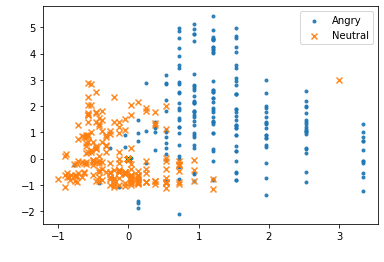

In [ ]:
plt.scatter(F0_test[np.where(F0_test[:,d]==0)][0],Soe_test[np.where(Soe_test[:,d]==0)][0],alpha = 0.9,marker='.',label='Angry')
plt.scatter(F0_test[np.where(F0_test[:,d]==3)][0],Soe_test[np.where(Soe_test[:,d]==3)][0],alpha = 0.9,marker='x',label='Neutral')
plt.xlabel('F0',color = 'white')
plt.ylabel('SoE',color = 'white')
plt.legend()


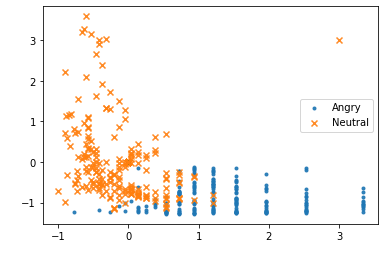

In [ ]:
plt.scatter(F0_test[np.where(F0_test[:,d]==0)][0],Eoe_test[np.where(Soe_test[:,d]==0)][0],alpha = 0.9,marker='.',label='Angry')
plt.scatter(F0_test[np.where(F0_test[:,d]==3)][0],Eoe_test[np.where(Soe_test[:,d]==3)][0],alpha = 0.9,marker='x',label='Neutral')
plt.xlabel('F0',color = 'white')
plt.ylabel('EoE',color = 'white')
plt.legend()

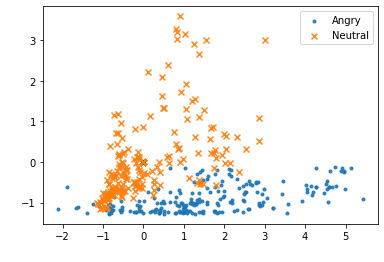

In [ ]:
plt.scatter(Soe_test[np.where(F0_test[:,d]==0)][0],Eoe_test[np.where(Soe_test[:,d]==0)][0],alpha = 0.9,marker='.',label='Angry')
plt.scatter(Soe_test[np.where(F0_test[:,d]==3)][0],Eoe_test[np.where(Soe_test[:,d]==3)][0],alpha = 0.9,marker='x',label='Neutral')
plt.xlabel('SoE',color = 'white')
plt.ylabel('EoE',color = 'white')
plt.legend()

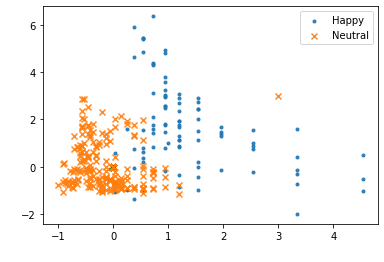

In [ ]:
plt.scatter(F0_test[np.where(F0_test[:,d]==1)][0],Soe_test[np.where(Soe_test[:,d]==1)][0],alpha = 0.9,marker='.',label='Happy')
plt.scatter(F0_test[np.where(F0_test[:,d]==3)][0],Soe_test[np.where(Soe_test[:,d]==3)][0],alpha = 0.9,marker='x',label='Neutral')
plt.xlabel('F0', color = 'white')
plt.ylabel('SoE', color = 'white')
plt.legend()

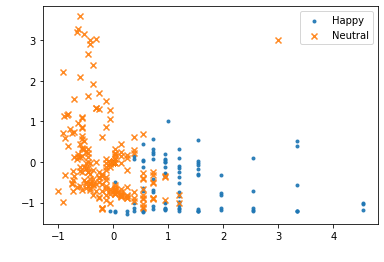

In [ ]:
plt.scatter(F0_test[np.where(F0_test[:,d]==1)][0],Eoe_test[np.where(Soe_test[:,d]==1)][0],alpha = 0.9,marker='.',label='Happy')
plt.scatter(F0_test[np.where(F0_test[:,d]==3)][0],Eoe_test[np.where(Soe_test[:,d]==3)][0],alpha = 0.9,marker='x',label='Neutral')
plt.xlabel('F0',color = 'white')
plt.ylabel('EoE', color = 'white')
plt.legend()

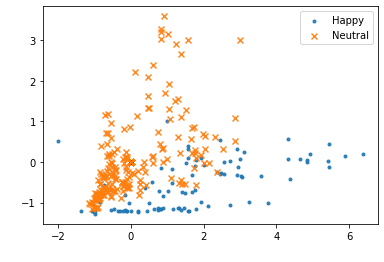

In [ ]:
plt.scatter(Soe_test[np.where(F0_test[:,d]==1)][0],Eoe_test[np.where(Soe_test[:,d]==1)][0],alpha = 0.9,marker='.',label='Happy')
plt.scatter(Soe_test[np.where(F0_test[:,d]==3)][0],Eoe_test[np.where(Soe_test[:,d]==3)][0],alpha = 0.9,marker='x',label='Neutral')
plt.xlabel('SoE',color = 'white')
plt.ylabel('EoE', color = 'white')
plt.legend()

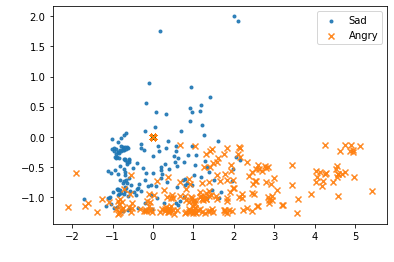

In [ ]:
plt.scatter(Soe_test[np.where(F0_test[:,d]==2)][0],Eoe_test[np.where(Soe_test[:,d]==2)][0],alpha = 0.9,marker='.',label='Sad')
plt.scatter(Soe_test[np.where(F0_test[:,d]==0)][0],Eoe_test[np.where(Soe_test[:,d]==0)][0],alpha = 0.9,marker='x',label='Angry')
plt.xlabel('SoE',color = 'white')
plt.ylabel('EoE', color = 'white')
plt.legend()

In [ ]:
k = 0
i = 5
for k in range(4):
    for i in range(4,15,3):
        emo = F0_test[np.where(F0_test[:,d]==k)][i,d]
        pred_emo = y_predict[np.where(F0_test[:,d]==k)][i]
        if emo == 0:
            emotion = "Angry"
        elif emo == 1:
            emotion = "Happy"
        elif emo == 2:
            emotion = "Sad" 
        else:
            emotion = "Neutral"
        if pred_emo == 0:
            pred_emotion = "Angry"
        elif pred_emo == 1:
            pred_emotion = "Happy"
        elif pred_emo == 2:
            pred_emotion = "Sad" 
        else:
            pred_emotion = "Neutral"
        print("Emotion of {}th test sample is : {}".format(i,emotion))
        print("Emotion of {}th predicted sample is : {}".format(i,pred_emotion))
        print()
    print("====================================")

Emotion of 4th test sample is : Angry
Emotion of 4th predicted sample is : Angry

Emotion of 7th test sample is : Angry
Emotion of 7th predicted sample is : Angry

Emotion of 10th test sample is : Angry
Emotion of 10th predicted sample is : Angry

Emotion of 13th test sample is : Angry
Emotion of 13th predicted sample is : Angry

Emotion of 4th test sample is : Happy
Emotion of 4th predicted sample is : Happy

Emotion of 7th test sample is : Happy
Emotion of 7th predicted sample is : Happy

Emotion of 10th test sample is : Happy
Emotion of 10th predicted sample is : Happy

Emotion of 13th test sample is : Happy
Emotion of 13th predicted sample is : Neutral

Emotion of 4th test sample is : Sad
Emotion of 4th predicted sample is : Sad

Emotion of 7th test sample is : Sad
Emotion of 7th predicted sample is : Sad

Emotion of 10th test sample is : Sad
Emotion of 10th predicted sample is : Sad

Emotion of 13th test sample is : Sad
Emotion of 13th predicted sample is : Sad

Emotion of 4th tes